## Méthode pour le Challenge

1) Créer un dataframe (style celui de la session 3) comprenant beaucoup de caractéristiques de la partie, générer beaucoup de parties dans lesquelles uniquement le rat gagne avec un random car cela permettra d'avoir bien plus de diversité qu'un algo greedy mais cela necessitera un filtra des données conséquent. A ce dataFrame on ajoute la liste des fromages que notre joueur est allé récupérer dans l'ordre de "dégustation". On a aussi rajouté une colonne indiquant la liste totale des fromages de la maze initiale dans le but de faciliter l'apprentissage du modèle, en effet lors de la prédiction, cette caractéristique permettra de guider le modèle à prédire une séquence qui inclut les cases où se trouvent les fromages.
2) Ensuite, on applique un modèle non supervisé permettant de réduire la dimension du dataframe en ne prenant que les données pertinentes et de trouver des corrélations entre les différentes features.
3) Ensuite, on applique un modèle supervisé de manière à entrainer notre modèle sur les différentes caractéristiques intéressantes du maze et les labels associés qui seront des listes de fromages à manger.
4) Pour tester la robustesse de notre modèle, nous allons regénérer un nouveau set de données qu'on testera, on utilisera la métrique de la matrice de confusion, la précision et le recall.


On peut aussi regarder si on peut améliorer le RL ou bien utiliser une partie du CGT pour notre IA

Problème:
En voulant générer les données via un modèle random, la probabilité d'obtenir une très bonne config est infiniment faible donc même en le faisant tourner 1 heure, je n'obtenais pas une partie pour laquelle il y a eu un miracle et donc que rat gagne (sachant qu'il nous faut un dataset d'environ 500 voir 1000 parties pour bien entrainer notre modèle ...).
Du coup, on a entrainé un modèle RL on prenant des hyperparamètres permettant d'avoir un programme pas trop mal puis on a uniquement conservé les parties pour lesquelles le rat a gagné "haut la main".

## <span style="color:red">1/ Preprocessing of the data</span>

### 1/ 0)  On charge le tableau csv issue des parties simulées

In [2]:
import pandas as pd
import ast
import matplotlib.pyplot as plt

# Lire le fichier CSV en spécifiant la fonction de conversion
#features avec 1000 parties
#features_maze = pd.read_csv('C:/Users/Frédéric/source/repos/introduction-to-ai/challenge/Result/features.csv', sep=";")
#features avec 2000 parties
#features_maze = pd.read_csv('C:/Users/Frédéric/source/repos/introduction-to-ai/challenge/Result/features_2000.csv', sep=";")
#features avec 4000 parties environs
csv1 = pd.read_csv('C:/Users/Frédéric/source/repos/introduction-to-ai/challenge/Result/features_4000.csv', sep=";")
#features avec 5000 parties environs
csv2 = pd.read_csv('C:/Users/Frédéric/source/repos/introduction-to-ai/challenge/Result/features_5000.csv', sep=";")

# On concatène les 2 fichiers csv afin d'avoir une plus grosse base de données = 10000 parties
features_maze = pd.concat([csv1, csv2], ignore_index=True)

# Charger les données
#features_maze = pd.read_csv('C:/Users/Frédéric/source/repos/introduction-to-ai/challenge/Result/features.csv', sep=";")

# On retire les colonnes correspondant à la liste des fromages et les identifiants de parties car illogique de calculer la variance dessus
column_to_drop = ["id",  " fromage_eaten(rat)"]
new_features_maze = features_maze.drop(columns=column_to_drop)

# On extrait la colonne qui correspondra aux labels
labels = features_maze[' fromage_eaten(rat)']

print('En moyenne, la différence de score est de :',features_maze[' score(rat) - score(python)'].mean())

En moyenne, la différence de score est de : 5.4126


### <span style="color:green">1/ a) Normalisation</span>

La normalisation permet de réduire les effets d'échelle des caractéristiques individuelles, cela va permettre d'améliorer les performances de l'algo d'apprentissage automatique ainsi que de retirer prochainement les features dont la variance est proche de 0.

In [3]:
from sklearn.preprocessing import MinMaxScaler

#On récupère toutes les valeurs car on souhaite normaliser toutes les colonnes
data_to_normalize = new_features_maze.values

#On initie une échelle de normalisation en normalisant selon la val max et la val min>
scaler = MinMaxScaler()

scaled_data = scaler.fit_transform(data_to_normalize)

# Reconstruction du DataFrame avec les données normalisées
normalized_df = pd.DataFrame(scaled_data, columns=new_features_maze.columns)

c:\Users\Frédéric\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\_array_api.py:472: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
c:\Users\Frédéric\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\_array_api.py:489: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))


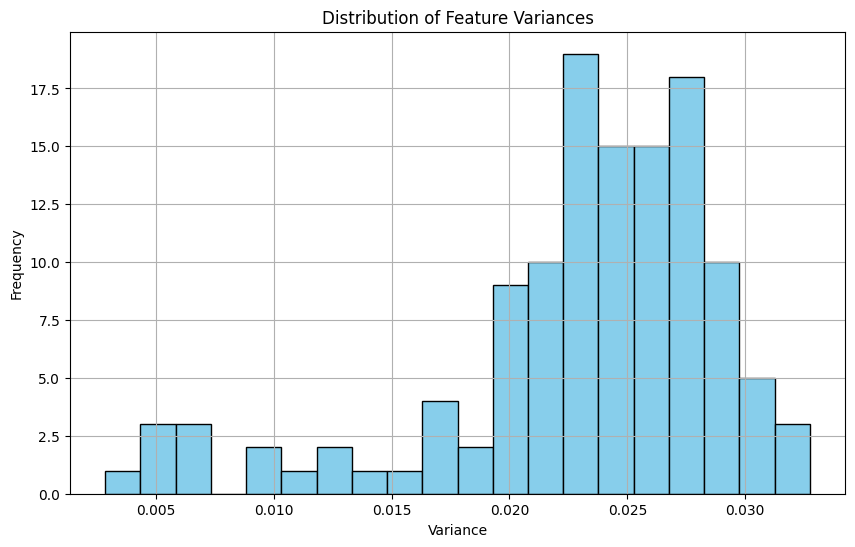

In [4]:
# Calculer la variance de chaque caractéristique
variances = normalized_df.var()

# Tracer l'histogramme de la variance
plt.figure(figsize=(10, 6))
plt.hist(variances, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Feature Variances')
plt.xlabel('Variance')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### <span style="color:green">1/ b) Dimension reduction through variance display</span>

In [5]:
from sklearn.feature_selection import VarianceThreshold

print('original features shape:')
print(normalized_df.shape)

thr = 0.015

selector = VarianceThreshold(threshold=thr)
new_normalized_data = selector.fit_transform(normalized_df)  # Utilisez un nom différent pour les données transformées

print('selected features shape')
print(new_normalized_data.shape)

print(f"{normalized_df.shape[1]-new_normalized_data.shape[1]} features were removed")

# Créer un DataFrame à partir des données transformées
new_normalized_df = pd.DataFrame(
    data=new_normalized_data,
    columns=normalized_df.columns[selector.get_support(indices=True)]  # Noms des colonnes sélectionnées
)

normalized_df = new_normalized_df


original features shape:
(10000, 125)
selected features shape
(10000, 111)
14 features were removed


c:\Users\Frédéric\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_selection\_variance_threshold.py:112: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)


## <span style="color:red">2/ Supervised model</span>

### <span style="color:green">2/ a) Splitting data into a training data_set and a test data_set</span>

In [18]:
# split dataset in train and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(new_normalized_df, labels.apply(ast.literal_eval), test_size=0.3, random_state=0)


### <span style="color:green">2/ b) Neural network model</span>

Composition : 
- couches denses
- couches de normalisation (permettant de faciliter l'apprentissage du réseau)
- couches de régularisation (cela met certaines valeurs de notre tenseur à 0, permet d'éviter le surajustage)

In [42]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

dim_layer2 = 200
dim_layer3 = 300

dropout_prob = 0.0

# Learning rate: détermine à quelle vitesse les points sont mis à jours. + le lr est faible est plus lente sera la convergence à l'inverse un lr élevé
# pourra entrainer des oscillations et une divergence du processus
lr = 0.01

# Utiliser le modèle avec les paramètres définis
input_size = len(new_normalized_df.columns)  # Taille de l'espace d'entrée = nombre de features présents dans le DataFrame
output_size = 40  # Taille de l'espace de sortie = nbr de fromages présents dans la maze
# La sortie sera un array (1,40) dont la hauteur de pondération indiquera quel fromage allé manger en premier etc...

class SequenceModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(SequenceModel, self).__init__()
        # Check if a GPU is available
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Le modèle doit renvoyer une liste de longueur max égale à max_seq_length contenant les fromages à aller manger 
        self.fc1 = nn.Linear(input_size, dim_layer2)
        # Cela permet de normaliser les activations intermédiaires et peut accélérer l'entraînement du modèle
        self.bn1 = nn.BatchNorm1d(dim_layer2)
        self.fc2 = nn.Linear(dim_layer2, dim_layer3)
        self.bn2 = nn.BatchNorm1d(dim_layer3)
        self.fc3 = nn.Linear(dim_layer3, output_size)
        # Régularisation : Cette technique va augmenter la difficulté pour notre modèle mais paradoxalement cela va le rendre plus performant
        # Aide à prévenir le surajustement en désactivant aléatoirement une fraction des neurones pendant l'entraînement
        self.dropout = nn.Dropout(dropout_prob)
    def forward(self, x):
        #x = F.relu(self.bn1(self.fc1(x))) # Permet d'ajouter de la non-linéarité dans le réseau 
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        #x = F.relu(self.bn2(self.fc2(x))) # Permet d'ajouter de la non-linéarité dans le réseau 
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Instancier le modèle avec les paramètres définis
model = SequenceModel(input_size, output_size)

# Utilisation de la fonction de perte personnalisée lors de l'entraînement
optimizer = torch.optim.SGD(model.parameters(), lr=lr)  # Permet de mettre à jour les poids du modèle
criterion = nn.MSELoss() # MeanSquaredError

In [9]:
#Fonction pour reset le réseau de neurones
def reset_weights(model):
    # Itérer à travers chaque couche du modèle
    for layer in model.children():
        # Vérifier si la couche a des poids
        if hasattr(layer, 'reset_parameters'):
            # Si oui, réinitialiser les poids de la couche
            layer.reset_parameters()

In [43]:
from sklearn.metrics import r2_score
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm 

batch_size = 150
# Convertir les données en tenseurs PyTorch puis créer des batchs de taille batch_size
train_data = TensorDataset(torch.tensor(X_train.values, dtype=torch.float), torch.tensor(np.vstack(y_train.values), dtype=torch.float))
# On coupe nos données d'entrainements en lots pour améliorer l'entrainement
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

#Initialisation des axes pour le graphe
num_epochs = 5000
prelevement_epoch= 500 # On prelève une mesure tous les 500 époques
r2_test_list = []
r2_training_list = []
Reset = True
#On reset le modèle 
if Reset : reset_weights(model)
# Convert it to GPU if possible
model = model.to(model.device)
# Assurez-vous que le modèle est en mode train
model.train()

# Boucle d'entraînement
for epoch in tqdm(range(num_epochs)):
    for batch_x, batch_y in train_loader:
        # Reset des gradients
        optimizer.zero_grad()
        # Calcul des prédictions
        outputs = model(batch_x.to(model.device))
        # Calcul de la perte
        loss = criterion(outputs, batch_y.to(model.device))
        # Rétropropagation
        loss.backward()
        # Mise à jour des poids
        optimizer.step()
    if (epoch+1)%prelevement_epoch == 0 :
        # Evaluation sur les données de test après chaque epoch (vous pouvez le modifier selon vos besoins)
        test_prediction = model(torch.tensor(X_test.values, dtype=torch.float).to(model.device)) 
        training_prediction = model(torch.tensor(X_train.values, dtype=torch.float).to(model.device))   
        test_prediction_numpy = test_prediction.cpu().detach().numpy()
        training_prediction_numpy = training_prediction.cpu().detach().numpy()

        y_test_tensor = torch.tensor(np.vstack(y_test.values), dtype=torch.float).to(model.device)
        y_test_numpy = y_test_tensor.cpu().detach().numpy()
        y_training_tensor = torch.tensor(np.vstack(y_train.values), dtype=torch.float).to(model.device)
        y_training_numpy = y_training_tensor.cpu().detach().numpy()
        r2_test_list.append(r2_score(y_test_numpy, test_prediction_numpy))
        r2_training_list.append(r2_score(y_training_numpy, training_prediction_numpy))

# Affichage de la courbe R2
Epoques = np.linspace(1000, num_epochs, int(num_epochs/prelevement_epoch))
plt.plot(Epoques, r2_test_list, label='Test R2')  # Courbe pour les données de test
plt.plot(Epoques, r2_training_list, label='Training R2')  # Courbe pour les données d'entraînement
plt.title('Evolution de R2 en fonction des époques')
plt.xlabel('Number of epochs')
plt.ylabel('Coefficient R2')
plt.legend()  # Ajout de la légende
plt.grid(True)
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [ ]:
# On reset les poids du modèle 
reset_weights(model)

In [36]:
# Convert it to GPU if possible
model = model.to(model.device)
# Ensure model is in train mode
model.train()

# Boucle d'entraînement
for epoch in range(num_epochs):
    # Reset gradients
    optimizer.zero_grad()
    # On convertie les labels (str) en de véritable liste (tableau numpy) afin de prendre leur longueur
    outputs = model.forward(torch.tensor(X_train.values, dtype = torch.float).to(model.device))  
    loss = criterion(outputs, torch.tensor(np.vstack(y_train.values), dtype = torch.float).to(model.device))  # Les labels sont des arrays numpy en format objet...
    print(loss)
    loss.backward()
    optimizer.step()
    

tensor(0.5716, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.5706, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.5695, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.5684, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.5674, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.5663, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.5652, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.5642, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.5631, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.5621, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.5611, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.5600, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.5590, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.5579, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.5569, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.5559, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.5549, device='cuda:0', grad_fn=

### METRIQUE DE NOTRE MODELE SUPERVISE

In [37]:
#  Generate the report and confusion matrix for the test set.
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

prediction = model.forward(torch.tensor(X_test.values, dtype = torch.float).to(model.device))  
# Transférer les prédictions du GPU vers le CPU
prediction_cpu = prediction.cpu()
prediction_numpy = prediction_cpu.detach().numpy()

y_test_tensor = torch.tensor(np.vstack(y_test.values), dtype = torch.float).to(model.device) # np.vstack permet de reshape les labels car ils sont de la forme [[],[],[]] au lieu de [[],\n[],\n[]]
# Transférer les étiquettes de test du GPU vers le CPU afin de convertir les tenseurs en array numpy
y_test_cpu = y_test_tensor.cpu()
y_test_numpy = y_test_cpu.detach().numpy()

# Calculer les métriques de régression
mse = mean_squared_error(y_test_numpy, prediction_numpy)
mae = mean_absolute_error(y_test_numpy, prediction_numpy)
r2 = r2_score(y_test_numpy, prediction_numpy)

print("Mean Squared Error:", mse)
print("Mean Absolute Error (moins sensible aux valeurs aberrantes que le MSE):", mae)
#Le R² est une mesure de la proportion de la variance dans la variable dépendante qui est prévisible à partir de la variable indépendante.
# 1 indique un ajustement parfait et 0 indique que le modèle n'explique pas du tout la variance des données.
print("Coefficient de détermination (R-squared) :", r2)

Mean Squared Error: 0.17699853
Mean Absolute Error (moins sensible aux valeurs aberrantes que le MSE): 0.35310736
Coefficient de détermination (R-squared) : -0.21559731294187512


In [38]:
#  Generate the report and confusion matrix for the test set.
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

train_prediction = model.forward(torch.tensor(X_train.values, dtype = torch.float).to(model.device))  
# Transférer les prédictions du GPU vers le CPU
train_prediction_cpu = train_prediction.cpu()
train_prediction_numpy = train_prediction_cpu.detach().numpy()

y_train_tensor = torch.tensor(np.vstack(y_train.values), dtype = torch.float).to(model.device) # np.vstack permet de reshape les labels car ils sont de la forme [[],[],[]] au lieu de [[],\n[],\n[]]
# Transférer les étiquettes de test du GPU vers le CPU afin de convertir les tenseurs en array numpy
y_train_cpu = y_train_tensor.cpu()
y_train_numpy = y_train_cpu.detach().numpy()

# Calculer les métriques de régression
mse = mean_squared_error(y_train_numpy, train_prediction_numpy)
mae = mean_absolute_error(y_train_numpy, train_prediction_numpy)
r2 = r2_score(y_train_numpy, train_prediction_numpy)

print("Mean Squared Error:", mse)
print("Mean Absolute Error (moins sensible aux valeurs aberrantes que le MSE):", mae)
#Le R² est une mesure de la proportion de la variance dans la variable dépendante qui est prévisible à partir de la variable indépendante.
# 1 indique un ajustement parfait et 0 indique que le modèle n'explique pas du tout la variance des données.
print("Coefficient de détermination (R-squared) :", r2)

Mean Squared Error: 0.11840777
Mean Absolute Error (moins sensible aux valeurs aberrantes que le MSE): 0.2889641
Coefficient de détermination (R-squared) : 0.19318237612277125


## Partie avec PCA

In [14]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

pca = PCA(n_components=0.95) # On conserve 60 % de la variance à expliquer
principal_components = pca.fit_transform(normalized_df)
# split dataset in train and test set

X_train, X_test, y_train, y_test = train_test_split(principal_components, labels.apply(ast.literal_eval), test_size=0.3, random_state=0)
print(principal_components.shape)

(10000, 71)


In [27]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

dim_layer2 = 100
dim_layer3 = 120
dim_layer4 = 140
dim_layer5 = 140
dim_layer6 = 120
dim_layer7 = 100

dropout_prob = 0.00

# Learning rate: détermine à quelle vitesse les points sont mis à jours. + le lr est faible est plus lente sera la convergence à l'inverse un lr élevé
# pourra entrainer des oscillations et une divergence du processus
lr = 0.01

# Utiliser le modèle avec les paramètres définis
input_size = principal_components.shape[1] # Taille de l'espace d'entrée = nombre de features présents dans le DataFrame
output_size = 40  # Taille de l'espace de sortie = nbr de fromages présents dans la maze
# La sortie sera un array (1,40) dont la hauteur de pondération indiquera quel fromage allé manger en premier etc...

class SequenceModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(SequenceModel, self).__init__()
        # Check if a GPU is available
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Le modèle doit renvoyer une liste de longueur max égale à max_seq_length contenant les fromages à aller manger 
        self.fc1 = nn.Linear(input_size, dim_layer2)
        # Cela permet de normaliser les activations intermédiaires et peut accélérer l'entraînement du modèle
        self.bn1 = nn.BatchNorm1d(dim_layer2)
        self.fc2 = nn.Linear(dim_layer2, dim_layer3)
        self.bn2 = nn.BatchNorm1d(dim_layer3)
        self.fc3 = nn.Linear(dim_layer3, dim_layer4)
        self.fc4 = nn.Linear(dim_layer4, dim_layer5)
        self.fc5 = nn.Linear(dim_layer5, dim_layer6)
        self.fc6 = nn.Linear(dim_layer6, dim_layer7)
        self.fc7 = nn.Linear(dim_layer7, output_size)
        # Régularisation : Cette technique va augmenter la difficulté pour notre modèle mais paradoxalement cela va le rendre plus performant
        # Aide à prévenir le surajustement en désactivant aléatoirement une fraction des neurones pendant l'entraînement
        self.dropout = nn.Dropout(dropout_prob)
    def forward(self, x):
        #x = F.relu(self.bn1(self.fc1(x))) # Permet d'ajouter de la non-linéarité dans le réseau 
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        #x = F.relu(self.bn2(self.fc2(x))) # Permet d'ajouter de la non-linéarité dans le réseau 
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))

        x = self.fc7(x)
        return x

# Instancier le modèle avec les paramètres définis
model = SequenceModel(input_size, output_size)

# Utilisation de la fonction de perte personnalisée lors de l'entraînement
optimizer = torch.optim.SGD(model.parameters(), lr=lr)  # Permet de mettre à jour les poids du modèle
criterion = nn.MSELoss() # MeanSquaredError

  0%|          | 0/50000 [00:00<?, ?it/s]

100%|██████████| 50000/50000 [2:44:57<00:00,  5.05it/s]  


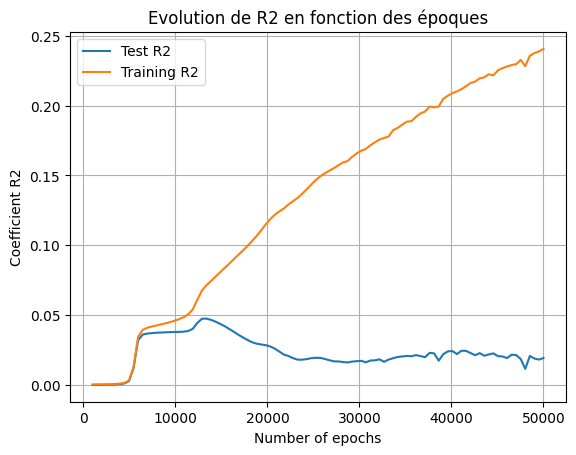

In [28]:
from sklearn.metrics import r2_score
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm 

batch_size = 200
# Convertir les données en tenseurs PyTorch puis créer des batchs de taille batch_size
train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float), torch.tensor(np.vstack(y_train.values), dtype=torch.float))
# On coupe nos données d'entrainements en lots pour améliorer l'entrainement
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

#Initialisation des axes pour le graphe
num_epochs = 50000
prelevement_epoch= 500 # On prelève une mesure tous les 500 époques
r2_test_list = []
r2_training_list = []
Reset = True
#On reset le modèle 
if Reset : reset_weights(model)
# Convert it to GPU if possible
model = model.to(model.device)
# Assurez-vous que le modèle est en mode train
model.train()

# Boucle d'entraînement
for epoch in tqdm(range(num_epochs)):
    for batch_x, batch_y in train_loader:
        # Reset des gradients
        optimizer.zero_grad()
        # Calcul des prédictions
        outputs = model(batch_x.to(model.device))
        # Calcul de la perte
        loss = criterion(outputs, batch_y.to(model.device))
        # Rétropropagation
        loss.backward()
        # Mise à jour des poids
        optimizer.step()
    if (epoch+1)%prelevement_epoch == 0 :
        # Evaluation sur les données de test après chaque epoch (vous pouvez le modifier selon vos besoins)
        test_prediction = model(torch.tensor(X_test, dtype=torch.float).to(model.device)) 
        training_prediction = model(torch.tensor(X_train, dtype=torch.float).to(model.device))   
        test_prediction_numpy = test_prediction.cpu().detach().numpy()
        training_prediction_numpy = training_prediction.cpu().detach().numpy()

        y_test_tensor = torch.tensor(np.vstack(y_test.values), dtype=torch.float).to(model.device)
        y_test_numpy = y_test_tensor.cpu().detach().numpy()
        y_training_tensor = torch.tensor(np.vstack(y_train.values), dtype=torch.float).to(model.device)
        y_training_numpy = y_training_tensor.cpu().detach().numpy()
        r2_test_list.append(r2_score(y_test_numpy, test_prediction_numpy))
        r2_training_list.append(r2_score(y_training_numpy, training_prediction_numpy))

# Affichage de la courbe R2
Epoques = np.linspace(1000, num_epochs, int(num_epochs/prelevement_epoch))
plt.plot(Epoques, r2_test_list, label='Test R2')  # Courbe pour les données de test
plt.plot(Epoques, r2_training_list, label='Training R2')  # Courbe pour les données d'entraînement
plt.title('Evolution de R2 en fonction des époques')
plt.xlabel('Number of epochs')
plt.ylabel('Coefficient R2')
plt.legend()  # Ajout de la légende
plt.grid(True)
plt.show()